# Load models from checkpoints and evaluate them on the evaluation tasks

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
from pathlib import Path

import molfeat
import pandas as pd
import torch
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from hydra.utils import instantiate
from lightning.pytorch.loggers import WandbLogger
from omegaconf import DictConfig, OmegaConf, open_dict

from src.models.jump_cl import BasicJUMPModule
from src.utils import instantiate_evaluator_list

In [7]:
for i in range(1, 4):
    if not Path(f"../cpjump{i}/jump/").exists():
        print(f"Mounting cpjump{i}...")
        os.system(f"sshfs bioclust:/projects/cpjump{i}/ ../cpjump{i}")
    else:
        print(f"cpjump{i} already mounted.")

cpjump1 already mounted.
cpjump2 already mounted.
cpjump3 already mounted.


In [1]:
"2023-08-17_13-32-50/0"run = 
epoch = 41

In [9]:
ckpt_str = "../cpjump1/jump/logs/train/multiruns/{run}/checkpoints/epoch_{epoch:0>3}.ckpt"

run_dict = {
    "small1": (run := "2023-08-16_11-59-26/0", "small_jump_cl", epoch := 43, ckpt_str.format(run=run, epoch=epoch)),
    "small": (run := "2023-08-17_13-32-50/0", "small_jump_cl", epoch := 41, ckpt_str.format(run=run, epoch=epoch)),
    "med": (run := "2023-08-07_11-55-54", "med_jump_cl", epoch := 5, ckpt_str.format(run=run, epoch=epoch)),
    "big": (run := "2023-08-01_11-37-40", "big_jump_cl", epoch := 1, ckpt_str.format(run=run, epoch=epoch)),
}

In [10]:
run, experiment, epoch, ckpt = run_dict["small"]

In [11]:
os.system(f"cat ../cpjump1/jump/logs/train/multiruns/{run}/.hydra/overrides.yaml");

- experiment=small_jump_cl
- trainer.devices=[0,2]
- data.num_workers=16
- data.prefetch_factor=2
- model/criterion=frozen_contrastive.yaml


In [12]:
os.listdir(f"../cpjump1/jump/logs/train/multiruns/{run}/checkpoints")

['last.ckpt', 'epoch_041.ckpt']

## Load the config and instantiate the model, loggers and evaluators

In [8]:
initialize(version_base=None, config_path="../configs/")

hydra.initialize()

In [13]:
run, experiment, epoch, ckpt = run_dict["small"]

In [144]:
cfg = compose(
    config_name="train.yaml",
    overrides=[
        "evaluate=true",
        "eval=retrieval",
        "paths.data_root_dir=../cpjump1",
        f"paths.output_dir=../cpjump1/jump/logs/train/multiruns/{run}",
        "model=fp_resnet",
        "model.embedding_dim=128",
        "data.batch_size=16",
        "data.num_workers=",
        "data.transform.size=128",
        "model.lr=4e-2",
        "trainer.devices=1",
        # "eval.moa_image_task.datamodule.data_root_dir=../",
    ],
)
print(OmegaConf.to_yaml(cfg))

task_name: train
tags:
- dev
train: true
test: true
evaluate: true
compile: false
ckpt_path: null
seed: null
data:
  compound_transform:
    _target_: src.modules.compound_transforms.fp_transform.FPTransform
    fps:
    - maccs
    - ecfp
    compound_str_type: smiles
    params:
      ecfp:
        radius: 2
  _target_: src.models.jump_cl.datamodule.BasicJUMPDataModule
  batch_size: 16
  num_workers: ''
  pin_memory: null
  prefetch_factor: null
  drop_last: null
  collate_fn:
    _target_: src.modules.collate_fn.dgl_image.image_graph_collate_function
    _partial_: true
  transform:
    _target_: src.modules.transforms.DefaultJUMPTransform
    _convert_: object
    size: 128
    dim:
    - -2
    - -1
  force_split: false
  splitter:
    _target_: src.splitters.ScaffoldSplitter
    train: ???
    test: ???
    val: ???
    retrieval: 0
  use_compond_cache: false
  split_path: ???
  dataloader_config:
    train:
      batch_size: ${data.batch_size}
      num_workers: ${data.num_worke

In [124]:
cfg.model.molecule_encoder.out_dim

128

In [148]:
molfeat.trans.concat.FeatConcat

molfeat.trans.concat.FeatConcat

In [149]:
"palzezr".lower()

'palzezr'

In [139]:
mol = instantiate(cfg.model)

In [145]:
dm = instantiate(cfg.data)

MissingMandatoryValue: Missing mandatory value: data.splitter.train
    full_key: data.splitter.train
    object_type=dict

In [134]:
mol

BasicJUMPModule(
  (image_encoder): CNNEncoder(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act1): ReLU(inplace=True)
          (aa): Identity()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
      

In [106]:
cfg.data.compound_transform

{'_target_': 'src.modules.compound_transforms.fp_transform.FPTransform', 'fps': ['maccs', 'ecfp'], 'compound_str_type': 'smiles', 'params': {'ecfp': {'radius': 2}}}

In [68]:
cfg.eval.idr_graph_retrieval.datamodule

{'_target_': 'src.eval.retrieval.datamodule.IDRRetrievalDataModule', 'selected_compounds_path': '${paths.data_root_dir}/excape-db/selected_compounds.csv', 'image_metadata_path': '${paths.data_root_dir}/idr0033-rohban-pathways/processed_metadata.csv', 'data_root_dir': '${paths.data_root_dir}/screen_1751', 'image_batch_size': 256, 'compound_batch_size': 16, 'num_workers': 16, 'pin_memory': False, 'prefetch_factor': 3, 'compound_transform': '${data.compound_transform}', 'transform': '${data.transform}', 'compound_gene_col': 'Gene_Symbol', 'image_gene_col': 'Gene Symbol', 'col_fstring': 'FileName_{channel}', 'channels': None, 'target_col': 'Activity_Flag', 'smiles_col': 'SMILES', 'use_cache': False, 'mol_collate_fn': None, 'img_collate_fn': None}

In [69]:
compound_transform = instantiate(cfg.eval.idr_graph_retrieval.datamodule)

In [74]:
cfg.model

{'image_encoder': {'_target_': 'src.modules.images.timm_pretrained.CNNEncoder', 'instance_model_name': 'resnet18', 'target_num': '${model.embedding_dim}', 'n_channels': 5, 'pretrained': True}, 'molecule_encoder': {'_target_': 'src.modules.molecules.dgllife_gin.GINPretrainedWithLinearHead', 'pretrained_name': 'gin_supervised_infomax', 'out_dim': '${model.embedding_dim}', 'pooling': 'mean', 'preload': True}, 'criterion': {'_target_': 'src.modules.losses.contrastive_loss_with_temperature.ContrastiveLossWithTemperature', 'logit_scale': 0, 'logit_scale_min': -1, 'logit_scale_max': 4.605170185988092, 'requires_grad': True}, 'optimizer': {'_target_': 'torch.optim.Adam', '_partial_': True, 'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0.01, 'amsgrad': False, 'lr': '${model.lr}'}, 'scheduler': {'_target_': 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts', '_partial_': True, 'T_0': 15, 'T_mult': 2, 'eta_min': 0, 'last_epoch': -1}, '_target_': 'src.models.jump_cl.module.BasicJUMPModu

In [15]:
moa_data = instantiate(cfg.eval.moa_image_task.datamodule)

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Plea

In [17]:
moa_data.prepare_data()

In [18]:
moa_data.setup("train")

In [21]:
moa_data.moa_load_df

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Site,FileName_OrigAGP,FileName_OrigDNA,FileName_OrigER,FileName_OrigMito,FileName_OrigRNA,InChIKey,moa,pert_type,smiles,Metadata_PlateType,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Sites_Per_Well,trt
0,source_11,Batch1,EC000004,J01,5,/projects/cpjump2/jump/images/source_11/Batch1...,/projects/cpjump2/jump/images/source_11/Batch1...,/projects/cpjump2/jump/images/source_11/Batch1...,/projects/cpjump2/jump/images/source_11/Batch1...,/projects/cpjump2/jump/images/source_11/Batch1...,IVUGFMLRJOCGAS-UHFFFAOYSA-N,Aurora kinase inhibitor,trt,Cc1csc(c1)-c1nnc(Nc2ccc(Oc3ncccc3-c3ccnc(N)n3)...,COMPOUND,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,9,compound_pos
1,source_8,J3,A1170528,B01,4,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,IVUGFMLRJOCGAS-UHFFFAOYSA-N,Aurora kinase inhibitor,trt,Cc1csc(c1)-c1nnc(Nc2ccc(Oc3ncccc3-c3ccnc(N)n3)...,COMPOUND,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,9,compound_pos
2,source_10,2021_06_08_U2OS_48_hr_run4,Dest210608-153057,J01,3,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,IVUGFMLRJOCGAS-UHFFFAOYSA-N,Aurora kinase inhibitor,trt,Cc1csc(c1)-c1nnc(Nc2ccc(Oc3ncccc3-c3ccnc(N)n3)...,COMPOUND,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,6,compound_pos
3,source_5,JUMPCPE-20210903-Run27_20210904_215148,APTJUM422,J01,8,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,IVUGFMLRJOCGAS-UHFFFAOYSA-N,Aurora kinase inhibitor,trt,Cc1csc(c1)-c1nnc(Nc2ccc(Oc3ncccc3-c3ccnc(N)n3)...,COMPOUND,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,9,compound_pos
4,source_9,20210914-Run9,GR00003301,Z24,3,/projects/cpjump1/jump/images/source_9/2021091...,/projects/cpjump1/jump/images/source_9/2021091...,/projects/cpjump1/jump/images/source_9/2021091...,/projects/cpjump1/jump/images/source_9/2021091...,/projects/cpjump1/jump/images/source_9/2021091...,IVUGFMLRJOCGAS-UHFFFAOYSA-N,Aurora kinase inhibitor,trt,Cc1csc(c1)-c1nnc(Nc2ccc(Oc3ncccc3-c3ccnc(N)n3)...,COMPOUND,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,4,compound_pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771,source_9,20210825_Run6,GR00003394,F13,2,/projects/cpjump1/jump/images/source_9/2021082...,/projects/cpjump1/jump/images/source_9/2021082...,/projects/cpjump1/jump/images/source_9/2021082...,/projects/cpjump1/jump/images/source_9/2021082...,/projects/cpjump1/jump/images/source_9/2021082...,VUIRVWPJNKZOSS-UHFFFAOYSA-N,ubiquitin specific protease inhibitor,trt,CC(C)c1ccccc1-c1ncc(C)c(NCc2ccc(cc2)-n2ccnn2)n1,TARGET2,JCP2022_096342,VUIRVWPJNKZOSS-UHFFFAOYSA-N,InChI=1S/C23H24N6/c1-16(2)20-6-4-5-7-21(20)23-...,4,target_trt
7772,source_9,20211103-Run16,GR00004409,V13,2,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,VUIRVWPJNKZOSS-UHFFFAOYSA-N,ubiquitin specific protease inhibitor,trt,CC(C)c1ccccc1-c1ncc(C)c(NCc2ccc(cc2)-n2ccnn2)n1,TARGET2,JCP2022_096342,VUIRVWPJNKZOSS-UHFFFAOYSA-N,InChI=1S/C23H24N6/c1-16(2)20-6-4-5-7-2

In [23]:
self = moa_data

In [29]:
test_ids = pd.read_csv(self.test_path, header=None).values.flatten().tolist()
train_ids = pd.read_csv(self.train_path, header=None).values.flatten().tolist()
val_ids = pd.read_csv(self.val_path, header=None).values.flatten().tolist()

In [31]:
moa_data.moa_load_df.iloc[train_ids].moa.value_counts()

moa
Aurora kinase inhibitor                        769
Bcr-Abl kinase inhibitor                       768
ubiquitin specific protease inhibitor          634
hepatocyte growth factor receptor inhibitor    612
bromodomain inhibitor                          612
DYRK inhibitor                                 612
JAK inhibitor                                  612
JNK inhibitor                                  607
phospholipase inhibitor                        606
Name: count, dtype: int64

In [32]:
moa_data.moa_load_df.iloc[val_ids].moa.nunique()

9

In [28]:
moa_data.moa_load_df.iloc[test_ids].moa.value_counts()

moa
Aurora kinase inhibitor                        103
Bcr-Abl kinase inhibitor                       102
ubiquitin specific protease inhibitor           85
hepatocyte growth factor receptor inhibitor     82
DYRK inhibitor                                  82
bromodomain inhibitor                           82
JNK inhibitor                                   81
phospholipase inhibitor                         81
JAK inhibitor                                   81
Name: count, dtype: int64

In [12]:
Path(ckpt).exists()

True

In [17]:
model2 = instantiate(cfg.model)

Pretrained model loaded


In [13]:
cfg.model["_target_"] += ".load_from_checkpoint"
with open_dict(cfg.model):
    cfg.model["checkpoint_path"] = ckpt

In [34]:
params = model2.parameters()
pparams = model.parameters()

In [41]:
next(params).to("cpu") == next(pparams).to("cpu")

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])

In [35]:
model = instantiate(cfg.model)

Pretrained model loaded


In [15]:
model

BasicJUMPModule(
  (image_encoder): CNNEncoder(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act1): ReLU(inplace=True)
          (aa): Identity()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
      

In [15]:
image_encoder = instantiate(cfg.model.image_encoder)
molecule_encoder = instantiate(cfg.model.molecule_encoder)
criterion = instantiate(cfg.model.criterion)

Pretrained model loaded


In [26]:
model = instantiate(cfg.model)

Pretrained model loaded


In [32]:
model = model.load_from_checkpoint(
    ckpt,
    image_encoder=image_encoder,
    molecule_encoder=molecule_encoder,
    criterion=criterion,
    example_input_path=None,
)

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'image_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['image_encoder'])`.
  rank_zero_warn(
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'molecule_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['molecule_encoder'])`.
  rank_zero_warn(
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
  rank_ze

In [48]:
model = instantiate(cfg.model)

Pretrained model loaded


/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'image_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['image_encoder'])`.
  rank_zero_warn(
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'molecule_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['molecule_encoder'])`.
  rank_zero_warn(
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
  rank_ze

In [16]:
model = BasicJUMPModule.load_from_checkpoint(
    ckpt,
    image_encoder=image_encoder,
    molecule_encoder=molecule_encoder,
    criterion=criterion,
    example_input_path=None,
    map_location=torch.device("cpu"),
)

In [18]:
logger = WandbLogger(project="evaluation_list")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gabriel-watkinson-work. Use `wandb login --relogin` to force relogin


In [19]:
evaluator_list = instantiate_evaluator_list(cfg.eval, cross_modal_module=model, logger=logger)

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Plea

In [20]:
evaluator_list[0].datamodule.moa_load_df_path

'../cpjump1/jump/models/eval/moa/image_task/moa_1024.csv'

In [21]:
evaluator_list[0].datamodule.prepare_data()

In [23]:
evaluator_list[0].datamodule.setup("train")

In [24]:
evaluator_list[0].datamodule.train_dataset.moa_load_df

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Site,FileName_OrigAGP,FileName_OrigDNA,FileName_OrigER,FileName_OrigMito,FileName_OrigRNA,InChIKey,moa,pert_type,smiles,Metadata_PlateType,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Sites_Per_Well,trt
0,source_8,J3,A1170541,J17,1,../cpjump2/jump/images/source_8/J3/A1170541/so...,../cpjump2/jump/images/source_8/J3/A1170541/so...,../cpjump2/jump/images/source_8/J3/A1170541/so...,../cpjump2/jump/images/source_8/J3/A1170541/so...,../cpjump2/jump/images/source_8/J3/A1170541/so...,SDGJBAUIGHSMRI-UHFFFAOYSA-N,AMPK inhibitor,trt,CCC(=O)Nc1cccc(Oc2nc(Nc3ccc(cc3OC)N3CCN(C)CC3)...,COMPOUND,JCP2022_082441,SDGJBAUIGHSMRI-UHFFFAOYSA-N,InChI=1S/C25H29ClN6O3/c1-4-23(33)28-17-6-5-7-1...,9,compound_trt
412,source_10,2021_06_01_U2OS_48_hr_run2,Dest210601-154302,B01,3,../cpjump3/jump/images/source_10/2021_06_01_U2...,../cpjump3/jump/images/source_10/2021_06_01_U2...,../cpjump3/jump/images/source_10/2021_06_01_U2...,../cpjump3/jump/images/source_10/2021_06_01_U2...,../cpjump3/jump/images/source_10/2021_06_01_U2...,IVUGFMLRJOCGAS-UHFFFAOYSA-N,Aurora kinase inhibitor,trt,Cc1csc(c1)-c1nnc(Nc2ccc(Oc3ncccc3-c3ccnc(N)n3)...,COMPOUND,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,6,compound_pos
6655,source_5,JUMPCPE-20210812-Run20_20210815_062625,ACPJUM102,I11,9,../cpjump2/jump/images/source_5/JUMPCPE-202108...,../cpjump2/jump/images/source_5/JUMPCPE-202108...,../cpjump2/jump/images/source_5/JUMPCPE-202108...,../cpjump2/jump/images/source_5/JUMPCPE-202108...,../cpjump2/jump/images/source_5/JUMPCPE-202108...,NBHPRWLFLUBAIE-UHFFFAOYSA-N,phospholipase inhibitor,trt,Oc1nc2cc(Cl)ccc2n1C1CCN(CCNC(=O)c2ccc(F)cc2)CC1,TARGET2,JCP2022_057881,NBHPRWLFLUBAIE-UHFFFAOYSA-N,InChI=1S/C21H22ClFN4O2/c22-15-3-6-19-18(13-15)...,9,target_trt
6448,source_3,CP_33_all_Phenix1,JCPQC032,D12,3,../cpjump2/jump/images/source_3/CP_33_all_Phen...,../cpjump2/jump/images/source_3/CP_33_all_Phen...,../cpjump2/jump/images/source_3/CP_33_all_Phen...,../cpjump2/jump/images/source_3/CP_33_all_Phen...,../cpjump2/jump/images/source_3/CP_33_all_Phen...,BCZUAADEACICHN-UHFFFAOYSA-N,hepatocyte growth factor receptor inhibitor,trt,Cn1cc(cn1)-c1ccc2nnc(Sc3ccc4ncccc4c3)n2n1,TARGET2,JCP2022_005529,BCZUAADEACICHN-UHFFFAOYSA-N,InChI=1S/C18H13N7S/c1-24-11-13(10-20-24)16-6-7...,9,target_trt
7073,source_4,2021_07_26_Batch9,BR00121427,I11,6,../cpjump1/jump/images/source_4/2021_07_26_Bat...,../cpjump1/jump/images/source_4/2021_07_26_Bat...,../cpjump1/jump/images/source_4/2021_07_26_Bat...,../cpjump1/jump/images/source_4/2021_07_26_Bat...,../cpjump1/jump/images/source_4/2021_07_26_Bat...,NBHPRWLFLUBAIE-UHFFFAOYSA-N,phospholipase inhibitor,trt,Oc1nc2cc(Cl)ccc2n1C1CCN(CCNC(=O)c2ccc(F)cc2)CC1,TARGET2,JCP2022_057881,NBHPRWLFLUBAIE-UHFFFAOYSA-N,InChI=1S/C21H22ClFN4O2/c22-15-3-6-19-18(13-15)...,9,target_trt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5289,source_6,p210831CPU2OS48hw384exp024JUMP,110000294901,C06,1,../cpjump3/jump/images/source_6/p210831CPU2OS4...,../cpjump3/jump/images/source_6/p210831CPU2OS4...,../cpjump3/jump/images/source_6/p210831CPU2OS4...,../cpjump3/jump/images/source_6/p210831CPU2OS4...,../cpjump3/jump/images/source_6/p210831CPU2OS4...,TXZPMHLMPKIUGK-UHFFFAOYSA-N,bromodomain inhibitor,trt,COc1ccccc1S(=O)(=O)Nc1ccc2NC(=O)N(C)Cc2c1,TARGET2,JCP2022_087474,TXZPMHLMPKIUGK-UHFFFAOYSA-N,InChI=1S/C16H17N3O4S/c1-19-10-11-9-12(7-8-13(1...,9,target_trt
1114,source_5,JUMPCPE-20210730-Run15_20210801_205335,ACPJUM081,J01,1,../cpjump2/jump/images/source_5/JUMPCPE-202107...,../cpjump2/jump/images/source_5/JUMPCPE-202107...,../cpjump2/jump/images/source_5/JUMPCPE-202107...,../cpjump2/jump/images/source_5/JUMPCPE-202107...,../cpjump2/jump/images/source_5/JUMPCPE-202107...,IIQUYGWWHIHOCF-UHFFFAOYSA-N,Bcr-Abl kinase inhibitor,trt,OCCNC(=O)c1cccc(c1)-c1ncnc(Nc2ccc(cc2)OC(F)(F)...,TARGET2,JCP2022_035296,IIQUYGWWHIHOCF-UHFFFAOYSA-N,"InChI=1S/C20H

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃ Name                ┃ Type             ┃ Params ┃         In sizes ┃ Out sizes ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 0  │ image_encoder       │ CNNEncoder       │ 11.2 M │ [4, 5, 256, 256] │  [4, 128] │
│ 1  │ head                │ Linear           │  3.4 K │         [4, 128] │   [4, 26] │
│ 2  │ criterion           │ CrossEntropyLoss │      0 │                ? │         ? │
│ 3  │ train_loss          │ MeanMetric       │      0 │                ? │         ? │
│ 4  │ val_loss            │ MeanMetric       │      0 │                ? │         ? │
│ 5  │ test_loss           │ MeanMetric       │      0 │                ? │         ? │
│ 6  │ train_other_metrics │ MetricCollection │      0 │                ? │         ? │
│ 7  │ val_other_metrics   │ MetricCollection │      0 │                ? │         ? │
│ 8  │ test_other_metrics  │ MetricCollection │      0 │                ? │         ? │
│ 9  │ train_plot_metrics  │ MetricCollection │      0 │                ? │         ? │
│ 10 │ val_plot_metrics    │ MetricCollection │      0 │                ? │         ? │
│ 11 │ test_plot_metrics   │ MetricCollection │      0 │                ? │         ? │
└────┴─────────────────────┴──────────────────┴────────┴──────────────────┴───────────┘

Trainable params: 13.0 K                                                                                           
Non-trainable params: 11.2 M                                                                                       
Total params: 11.3 M                                                                                               
Total estimated model params size (MB): 45

Output()

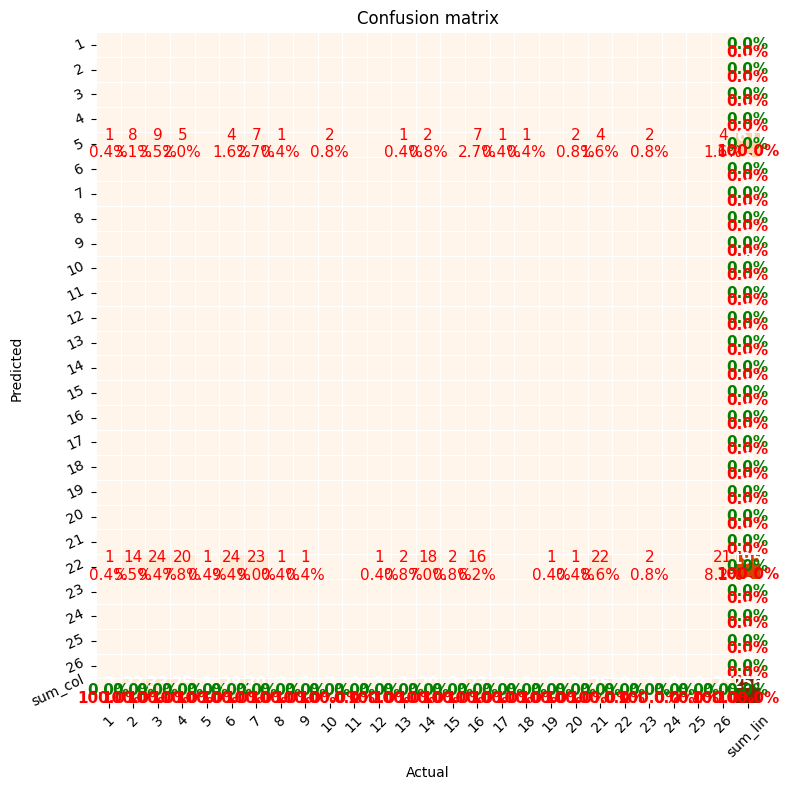

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:42: 
UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in 
true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028

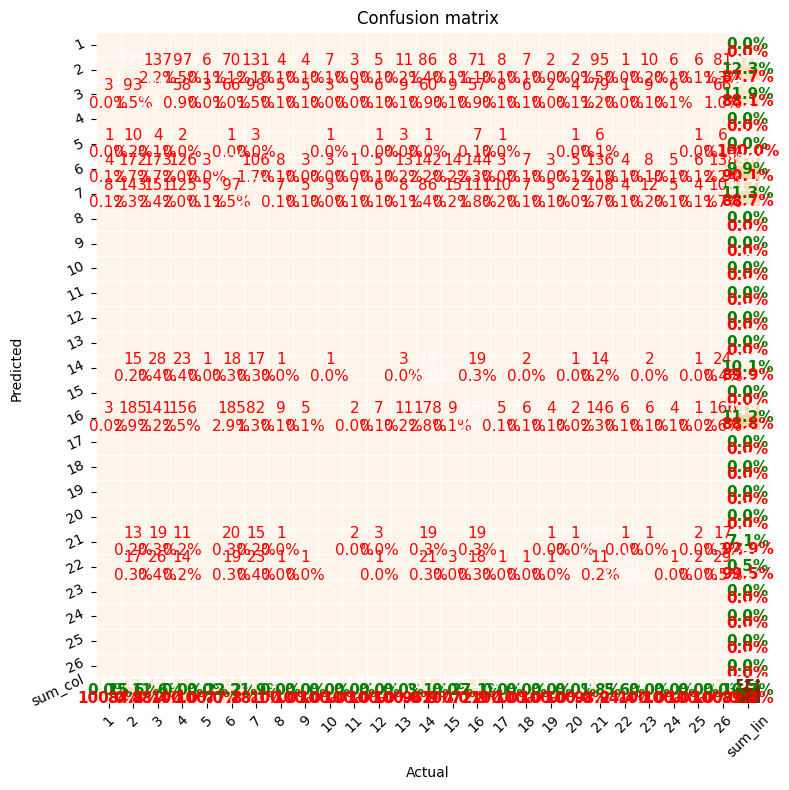

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:53: 
UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

AttributeError: 'JumpMOADataModule' object has no attribute 'iloc'

In [25]:
evaluator_list[0].run()

In [44]:
evaluator_list[0].datamodule.train_dataset[0]

FileNotFoundError: [Errno 2] No such file or directory: '/projects/cpjump2/jump/images/source_8/J3/A1170541/source_8__A1170541__J17__1__DNA.png'

In [34]:
evaluator_list[0].datamodule.moa_load_df_path

['_log_hyperparams',
 'prepare_data_per_node',
 'allow_zero_length_dataloader_with_multiple_devices',
 'trainer',
 'moa_load_df_path',
 'split_path',
 'force_split',
 'transform',
 'compound_transform',
 'collate_fn',
 'metadata_dir',
 'load_data_dir',
 'train_path',
 'val_path',
 'test_path',
 'splitter',
 'max_obs_per_class',
 'target_col',
 'smiles_col',
 'return_image',
 'return_compound',
 'use_cache',
 'got_default_collate_fn',
 'batch_size',
 'num_workers',
 'pin_memory',
 'prefetch_factor',
 'moa_load_df',
 'train_dataset',
 'val_dataset',
 'test_dataset',
 '__module__',
 '__init__',
 'prepare_data',
 'setup',
 'train_dataloader',
 'val_dataloader',
 'test_dataloader',
 'teardown',
 'state_dict',
 'load_state_dict',
 '__repr__',
 '__doc__',
 '__annotations__',
 'name',
 'CHECKPOINT_HYPER_PARAMS_KEY',
 'CHECKPOINT_HYPER_PARAMS_NAME',
 'CHECKPOINT_HYPER_PARAMS_TYPE',
 'from_datasets',
 'load_from_checkpoint',
 'predict_dataloader',
 'transfer_batch_to_device',
 'on_before_batch_t

In [30]:
evaluator_list.run()

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃ Name                ┃ Type             ┃ Params ┃         In sizes ┃ Out sizes ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 0  │ image_encoder       │ CNNEncoder       │ 11.2 M │ [4, 5, 256, 256] │  [4, 128] │
│ 1  │ head                │ Linear           │  3.4 K │         [4, 128] │   [4, 26] │
│ 2  │ criterion           │ CrossEntropyLoss │      0 │                ? │         ? │
│ 3  │ train_loss          │ MeanMetric       │      0 │                ? │         ? │
│ 4  │ val_loss            │ MeanMetric       │      0 │                ? │         ? │
│ 5  │ test_loss           │ MeanMetric       │      0 │                ? │         ? │
│ 6  │ train_other_metrics │ MetricCollection │      0 │                ? │         ? │
│ 7  │ val_other_metrics   │ MetricCollection │      0 │                ? │         ? │
│ 8  │ test_other_metrics  │ MetricCollection │      0 │                ? │         ? │
│ 9  │ train_plot_metrics  │ MetricCollection │      0 │                ? │         ? │
│ 10 │ val_plot_metrics    │ MetricCollection │      0 │                ? │         ? │
│ 11 │ test_plot_metrics   │ MetricCollection │      0 │                ? │         ? │
└────┴─────────────────────┴──────────────────┴────────┴──────────────────┴───────────┘

Trainable params: 13.0 K                                                                                           
Non-trainable params: 11.2 M                                                                                       
Total params: 11.3 M                                                                                               
Total estimated model params size (MB): 45

Output()

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/mnt/2547d4d7-6732-4154-b0e1-17b0c1e0c565/Document-2/Projet2/Stage/workspace/jump_models/src/eval/moa/datamodule.py", line 128, in __getitem__
    img_array = load_image_paths_to_array(img_paths)  # A numpy array: (5, 768, 768)
  File "/mnt/2547d4d7-6732-4154-b0e1-17b0c1e0c565/Document-2/Projet2/Stage/workspace/jump_models/src/utils/io.py", line 77, in load_image_paths_to_array
    images.append(np.array(Image.open(image_path)))
  File "/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/PIL/Image.py", line 3236, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/projects/cpjump2/jump/images/source_8/J3/A1170541/source_8__A1170541__J17__1__DNA.png'
